In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Nadam
from keras.models import load_model

from data import Data

from neural_network import create_nn

from neural_network_utils import auc

from ml_utils import print_roc, evaluate, best_threshold

from features import FeatureExtractor

import pandas as pd

import numpy as np

/Users/nathanhartmann/Desktop/cwi-workshop/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [55]:
embeddings_path = '/Users/nathanhartmann/Desktop/cwi_utils/glove.100d.bin'
#embeddings_path = './glove.100d.bin'
neural_network_model_path = '/Users/nathanhartmann/Desktop/cwi_utils/model.h5'
#neural_network_model_path = './model_2relu_sigmoid.h5'
training_data = ['datasets/english/News_Train.tsv',
                 'datasets/english/WikiNews_Train.tsv',
                 'datasets/english/Wikipedia_Train.tsv',
                ]
dev_data = ['datasets/english/News_Dev.tsv',
            'datasets/english/WikiNews_Dev.tsv',
            'datasets/english/Wikipedia_Dev.tsv'
           ]
dev_data_news = ['datasets/english/News_Dev.tsv',
            ]
dev_data_wikinews = ['datasets/english/WikiNews_Dev.tsv',
            ]
dev_data_wikipedia = ['datasets/english/Wikipedia_Dev.tsv',
            ]
test_data = ['datasets/english/News_Test.tsv',
            'datasets/english/WikiNews_Test.tsv',
            'datasets/english/Wikipedia_Test.tsv'
           ]
test_data_news = ['datasets/english/News_Test.tsv',
            ]
test_data_wikinews = ['datasets/english/WikiNews_Test.tsv',
            ]
test_data_wikipedia = ['datasets/english/Wikipedia_Test.tsv',
            ]

-----
# Features extraction

In [59]:
data_train = Data(training_data)
data_dev = Data(dev_data)
data_test = Data(test_data, is_test=True)

data_dev_news = Data(dev_data_news)
data_dev_wikinews = Data(dev_data_wikinews)
data_dev_wikipedia = Data(dev_data_wikipedia)

data_test_news = Data(test_data_news, is_test=True)
data_test_wikinews = Data(test_data_wikinews, is_test=True)
data_test_wikipedia = Data(test_data_wikipedia, is_test=True)

In [60]:
fe = FeatureExtractor(embedding_model_path=embeddings_path)

x_train = fe.predict_average_embeddings(data_train.instances)
y_train, y_train_prob = data_train.y, data_train.y_prob

x_dev = fe.predict_average_embeddings(data_dev.instances)
y_dev, y_dev_prob = data_dev.y, data_dev.y_prob

x_test = fe.predict_average_embeddings(data_test.instances)
y_test, y_test_prob = data_test.y, data_test.y_prob

# DEV
x_dev_news = fe.predict_average_embeddings(data_dev_news.instances)
y_dev_news, y_dev_news_prob = data_dev_news.y, data_dev_news.y_prob

x_dev_wikinews = fe.predict_average_embeddings(data_dev_wikinews.instances)
y_dev_wikinews, y_dev_wikinews_prob = data_dev_wikinews.y, data_dev_wikinews.y_prob

x_dev_wikipedia = fe.predict_average_embeddings(data_dev_wikipedia.instances)
y_dev_wikipedia, y_dev_wikipedia_prob = data_dev_wikipedia.y, data_dev_wikipedia.y_prob

# TEST
x_test_news = fe.predict_average_embeddings(data_test_news.instances)

x_test_wikinews = fe.predict_average_embeddings(data_test_wikinews.instances)

x_test_wikipedia = fe.predict_average_embeddings(data_test_wikipedia.instances)

-----
# Training neural network

In [82]:
model = create_nn()
#optimizer = Adam(lr=1e-6)
optimizer = Nadam(lr=2e-3, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
callbacks_list = [ModelCheckpoint('/Users/nathanhartmann/Desktop/model.h5', monitor='val_auc', verbose=1, save_best_only=True, mode='max'),]
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[auc])

model.fit(
    x_train,
    y_train,
    validation_data=(x_dev, y_dev),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_list)

Train on 27299 samples, validate on 3328 samples
Epoch 1/20
27299/27299 [==============================] - 54s 2ms/step - loss: 0.4925 - auc: 0.8337 - val_loss: 0.5210 - val_auc: 0.8474

Epoch 00001: val_auc improved from -inf to 0.84742, saving model to /Users/nathanhartmann/Desktop/model.h5
Epoch 2/20
27299/27299 [==============================] - 20s 737us/step - loss: 0.4290 - auc: nan - val_loss: 0.4459 - val_auc: 0.8681

Epoch 00002: val_auc improved from 0.84742 to 0.86810, saving model to /Users/nathanhartmann/Desktop/model.h5
Epoch 3/20
27299/27299 [==============================] - 20s 743us/step - loss: 0.3973 - auc: 0.8984 - val_loss: 0.4482 - val_auc: 0.8725

Epoch 00003: val_auc improved from 0.86810 to 0.87246, saving model to /Users/nathanhartmann/Desktop/model.h5
Epoch 4/20
27299/27299 [==============================] - 20s 735us/step - loss: 0.3733 - auc: 0.9100 - val_loss: 0.4252 - val_auc: 0.8844

Epoch 00004: val_auc improved from 0.87246 to 0.88444, saving model t

-----
# Predicting

In [12]:
model = load_model(neural_network_model_path, custom_objects={'auc':auc})

--Optimizing f1--


/Users/nathanhartmann/Desktop/cwi-workshop/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Threshold: 0.50
--Scores--
Accuracy: 0.82
Precision: 0.77
Recall: 0.79
F1: 0.78
--Confusion matrix:--
 [[1653  324]
 [ 287 1064]]


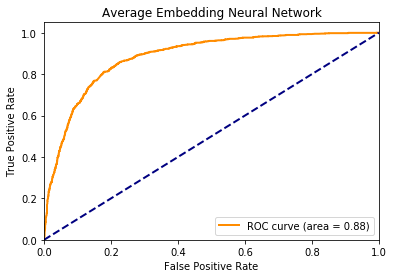

In [65]:
pred_train= model.predict(x_train)
pred_dev = model.predict(x_dev)
evaluate(pred_train, pred_dev, y_train, y_dev, optimize='f1', label='Average Embedding Neural Network')

In [58]:
pred_test_news = model.predict(x_test_news)
pred_test_wikinews = model.predict(x_test_wikinews)
pred_test_wikipedia = model.predict(x_test_wikipedia)

print(pred_test_news.shape)
print(pred_test_wikinews.shape)
print(pred_test_wikipedia.shape)
#pd.DataFrame(pred_test_news).to_csv('/Users/nathanhartmann/Desktop/pred_test_news.tsv', index=False, header=False)

(2095, 1)
(1287, 1)
(870, 1)
